Creates Figure 6-10 based on the .txt runtime info files returned by the ODE-Test

In [1]:
import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd

#Creates the plots for the ODE model (Fig.3-5) 
#based on the databases created in the Tests


font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
from matplotlib import rc
rc('font', **font)

samplers_color =["#8AA8A1", "#885A89", "#CBCBD4"]



In [2]:
# Fix some global variables


nodes = 8
noisevar = 0.03

sleepvars=[1.0, 2.0, 4.0]

basepath = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_T2"


pop_sizes = [20, 80, 320, 1280]

eps_list=[8, 4, 2, 1, 0.7,  0.5, 0.33, 0.25]
eps = pyabc.ListEpsilon(eps_list)

iters_LA=[13,13,13,13,13]
iters_LA_fix=[13,13,13,13,13]
iters_ORI=[13,13,13,13,13]
iters_STAT=[3,3,3]

#---------------------
col_names=["theta1_means", "theta1_stds", "effective_sample_size", "theta2_means", "theta2_stds"]

outputpath = outputpath = os.getcwd() + "/T2_figures"


In [3]:
def load_histories(basepath, look_ahead, iters, sleepvar, popsize):
    """
    Reads in all databases as pyABC History objects
    """
    histories = []
    for i in range(iters):
#         print(sleepvar, look_ahead, popsize, i)
        path=os.path.join(basepath,
                          "results/Var"+str(sleepvar)+"/database", 
                          str(look_ahead)+str(nodes)+"_"+str(popsize)+"_"+str(i)+".db")
#         print(str(path))
        histories.append(pyabc.History("sqlite:///" + path))
    return histories

histories_LA=load_histories(basepath, "DYNLA_pre", iters_LA[0], sleepvars[0], pop_sizes[-1])
histories_LA_fix=load_histories(basepath, "DYNLA", iters_LA_fix[0], sleepvars[0], pop_sizes[-1])
histories_ORI=load_histories(basepath, "ORI", iters_ORI[0], sleepvars[1], pop_sizes[-1])
histories_STATIC=load_histories(basepath, "STATIC", iters_STAT[0], sleepvars[0], pop_sizes[-1])



def get_data(histories, iters):
    """
    Extracts the relevant data from the history objects
    """
    alldata=np.zeros((iters, len(col_names)))
    for i in range(iters):
        df,w= histories[i].get_distribution(t=histories[i].max_t)
#         print(i)
        points = df['theta1'].values
        alldata[i,0]=pyabc.weighted_statistics.weighted_mean(points,w)
        alldata[i,1]=pyabc.weighted_statistics.weighted_std(points,w)

        points = df['theta2'].values
        alldata[i,3]=pyabc.weighted_statistics.weighted_mean(points,w)
        alldata[i,4]=pyabc.weighted_statistics.weighted_std(points,w)

        alldata[i,2]=pyabc.weighted_statistics.effective_sample_size(w)

    return np.array(alldata)

alldata_LA=get_data(histories_LA, iters_LA[0])
alldata_LA_fix=get_data(histories_LA_fix, iters_LA_fix[0])
alldata_ORI=get_data(histories_ORI, iters_ORI[0])


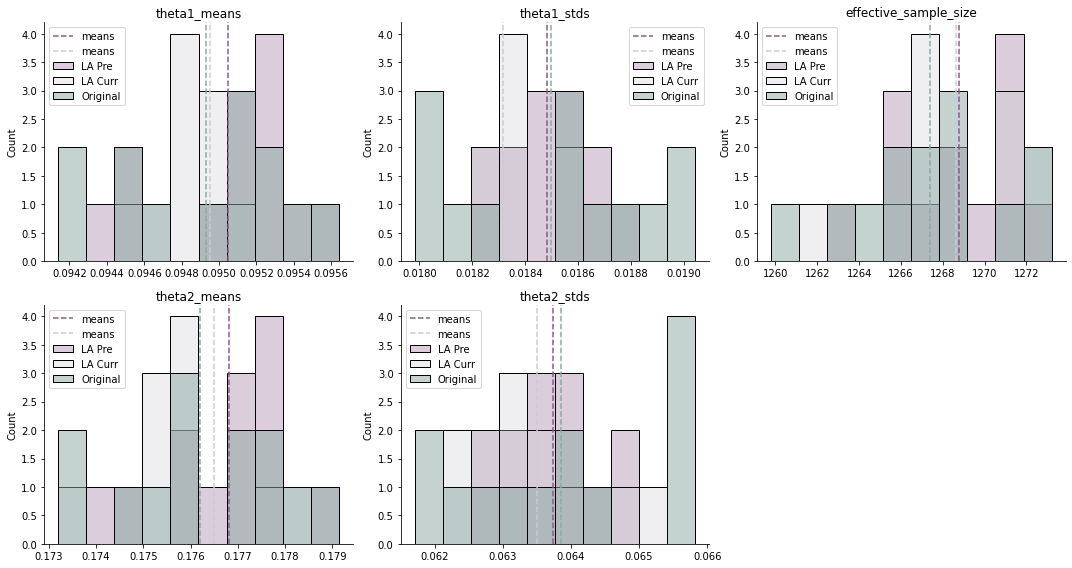

In [4]:
# Creation of a histogram comparing the means, STDs and the effective sample size
fig = plt.figure(figsize=(15,8))
nx, ny=2, 3

for i in range(len(col_names)):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(col_names[i])

    bins=10
    binrange_min=min(alldata_LA[:,i].min(),alldata_ORI[:,i].min())
    binrange_max=max(alldata_LA[:,i].max(),alldata_ORI[:,i].max())
    sns.histplot(alldata_LA[:,i], ax = ax, bins = bins,
                 binrange = (binrange_min, binrange_max), common_bins = True,
                 kde=False, label="LA Pre", color = samplers_color[1], alpha = 0.3)
    sns.histplot(alldata_LA_fix[:,i], ax = ax, bins = bins,
                 binrange = (binrange_min, binrange_max), common_bins = True,
                 kde=False, label="LA Curr", color = samplers_color[2], alpha = 0.3)
    sns.histplot(alldata_ORI[:,i], ax = ax, bins = bins,
                 binrange = (binrange_min, binrange_max), common_bins = True,
                 kde=False, label="Original", color = samplers_color[0], alpha = 0.5)
    ax.axvline(x = alldata_LA[:,i].mean(), label="means", color=samplers_color[1], linestyle="dashed")
    ax.axvline(x = alldata_LA_fix[:,i].mean(), label="means", color=samplers_color[2], linestyle="dashed")
    ax.axvline(x = alldata_ORI[:,i].mean(),color=samplers_color[0], linestyle="dashed")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEMeansIEcomparision.pdf"))


#-------------------



In [5]:
def data_to_frame(basepath, look_aheads, alliters, sleepvars, pop_sizes):
    """
    Converts data to a pandas dataframe to later create the boxplots
    """
    allframes = []
    for i in range(len(alliters)):
        for k in pop_sizes:
            for l in range(len(sleepvars)):

                keks = load_histories(basepath, look_aheads[i], alliters[i][l] , sleepvars[l], k)
                keksarray = get_data(keks, alliters[i][l])
                keksframe = pd.DataFrame(keksarray, columns=col_names)
                if look_aheads[i]=='LA_Pre':
                    keksframe['Scheduling'] = "LA"
                elif look_aheads[i]=='LA_Curr':
                    keksframe['Scheduling'] = "LA_Curr"
                elif look_aheads[i]=='ORI':
                    keksframe['Scheduling'] = "DYN"
                else: keksframe['Scheduling'] = look_aheads[i]
                keksframe['LNVariance'] = sleepvars[l]
                keksframe['Pop_size'] = k
                allframes.append(keksframe)

    df = pd.concat(allframes)
    return df

FullDFVar=data_to_frame(basepath, ["DYNLA_pre", "DYNLA","ORI"], [iters_LA, iters_LA_fix, iters_ORI], sleepvars, [pop_sizes[-1]])
FullDFVar_N256=data_to_frame(basepath, ["DYNLA_pre", "DYNLA","ORI"], [iters_LA, iters_LA_fix, iters_ORI], sleepvars, [pop_sizes[0]])
FullDFPop=data_to_frame(basepath, ["DYNLA_pre", "DYNLA","ORI"], [iters_LA, iters_LA_fix, iters_ORI], [1.0], pop_sizes)


Here we calculate the parallel efficiencies as runtime(1 worker)/ (W runtime(W workers))

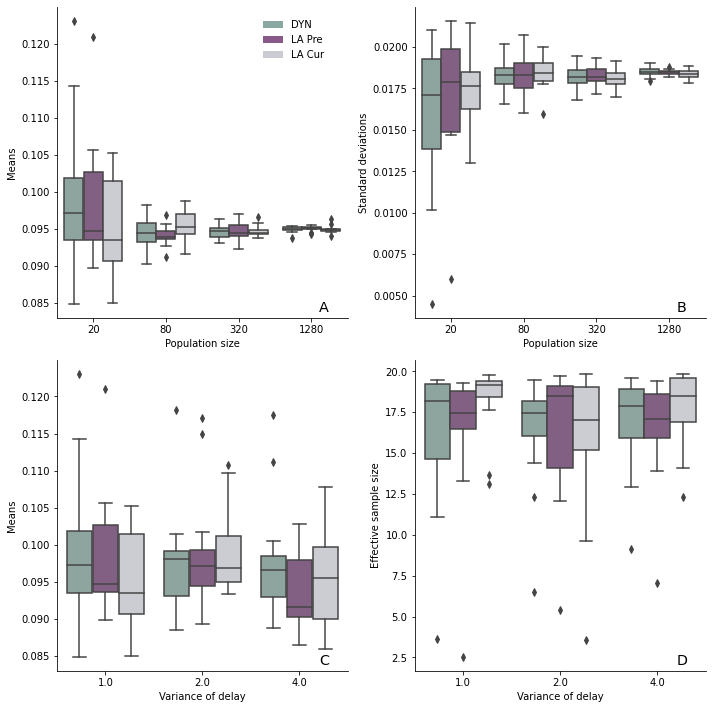

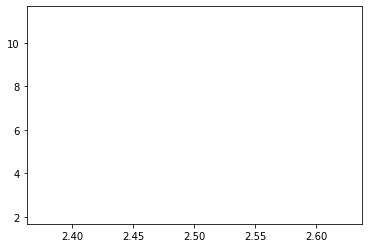

In [6]:
# Creaton of the Boxplots (Figure 4)


fig,axes=plt.subplots(2, 2, figsize=(10,10))

ax = axes[0][0]
sns.boxplot(x="Pop_size",y=col_names[0], hue="Scheduling",
            data=FullDFPop, ax=axes[0][0], hue_order=["DYN","DYNLA_pre","DYNLA"], palette=[samplers_color[0], samplers_color[1], samplers_color[2]])
#l1=plt.bar([0],[0],0 ,label="A", color='white')
#axes[0][0].set_title("A: Means; z=1")
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
ax.text(xmin+0.9*(xmax-xmin),ymin+0.02*(ymax-ymin),'A', fontsize="x-large")
ax.set_xlabel("Population size")
ax.set_ylabel("Means")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend([],[], frameon=False)#, loc='upper left', bbox_to_anchor = (-0.05,1))


ax = axes[0][1]
sns.boxplot(x="Pop_size",y=col_names[1], hue="Scheduling",
            data=FullDFPop, ax=ax, hue_order=["DYN","DYNLA_pre","DYNLA"], palette=[samplers_color[0], samplers_color[1], samplers_color[2]])
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
ax.text(xmin+0.9*(xmax-xmin),ymin+0.02*(ymax-ymin),'B', fontsize="x-large")
#axes[0][1].set_title("B: Standard deviation; z=1")
axes[0][1].set_xlabel("Population size")
axes[0][1].set_ylabel("Standard deviations")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axes[0][1].tick_params(axis='both', which='major', labelsize=10)
ax.legend([],[], frameon=False)


ax = axes[1][0]
sns.boxplot(x="LNVariance",y=col_names[0], hue="Scheduling",
            data=FullDFVar_N256, ax=axes[1][0], hue_order=["DYN","DYNLA_pre","DYNLA"], palette=[samplers_color[0], samplers_color[1], samplers_color[2]])
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
ax.text(xmin+0.9*(xmax-xmin),ymin+0.02*(ymax-ymin),'C', fontsize="x-large")
#axes[1][0].set_title("C: Means; N=4096")
axes[1][0].set_xlabel("Variance of delay")
axes[1][0].set_ylabel("Means")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
axes[1][0].tick_params(axis='both', which='major', labelsize=10)
ax.legend([],[], frameon=False)


ax = axes[1][1]
sns.boxplot(x="LNVariance",y=col_names[2], hue="Scheduling",
            data=FullDFVar_N256, ax=axes[1][1], hue_order=["DYN","DYNLA_pre","DYNLA"], palette=[samplers_color[0], samplers_color[1], samplers_color[2]])
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
ax.text(xmin+0.9*(xmax-xmin),ymin+0.02*(ymax-ymin),'D', fontsize="x-large")
#axes[1][1].set_title("D: Effective sample sizes; N=256")
axes[1][1].set_xlabel("Variance of delay")
axes[1][1].set_ylabel("Effective sample size")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
axes[1][1].tick_params(axis='both', which='major', labelsize=10)
ax.legend([],[], frameon=False)


legend, axi = plt.subplots()
ax = axi
l1=ax.bar([xmax],[0.5*(ymax-ymin)],0, bottom = ymin, color=samplers_color[0])
l2=ax.bar([xmax],[0.5*(ymax-ymin)],0, bottom = ymin, color=samplers_color[1])
l3=ax.bar([xmax],[0.5*(ymax-ymin)],0, bottom = ymin, color=samplers_color[2])
labels=["DYN","LA Pre", "LA Cur"]

axes[0][0].legend([l1,l2,l3],labels, loc='lower right', bbox_to_anchor = (0.95, 0.8), frameon=False)
fig.tight_layout()

fig.savefig(os.path.join(str(outputpath), "ODEBoxPlots_v2.pdf"))


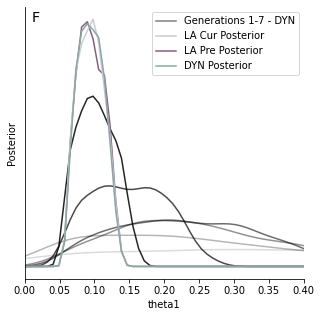

In [7]:
#---------------------


# Plots the posteriors and their development (Figure 3)

rep=12
xmax = 0.4
max_t=histories_LA[rep].max_t

fig,ax = plt.subplots(1,1, figsize=(5,5))

for i in range(max_t):
    df,w = histories_ORI[rep].get_distribution(m=0,t=i)
    pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color='black', alpha=(i)/max_t, xmin = 0, xmax=xmax)

df, w = histories_LA[rep].get_distribution(m=0,t=max_t)
pyabc.visualization.plot_kde_1d(df, w, x='theta1',ax=ax, color=samplers_color[1], xmin = 0, xmax=xmax)
df_fix, w_fix = histories_LA_fix[rep].get_distribution(m=0,t=max_t)
pyabc.visualization.plot_kde_1d(df_fix, w_fix, x='theta1',ax=ax, color=samplers_color[2], xmin = 0, xmax=xmax)

df_ori, w_ori = histories_ORI[rep].get_distribution(m=0,t=histories_ORI[rep].max_t)
pyabc.visualization.plot_kde_1d(df_ori, w_ori, x='theta1',ax=ax, color=samplers_color[0], xmin = 0, xmax=xmax)

#ax.axvline(x = alldata_LA[:, 0].mean(), color="blue", linestyle="dashed")
#ax.axvline(x = alldata_ORI[:, 0].mean(), color="orange", linestyle="dashed")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(0,0, color='black', alpha=0.5, label= "Generations 1-"+str(max_t)+" - DYN")
ax.plot(0,0, color=samplers_color[2], label='LA Cur Posterior')
ax.plot(0,0, color=samplers_color[1], label='LA Pre Posterior')
ax.plot(0,0, color=samplers_color[0], label='DYN Posterior')
#ax.plot(0,0, linestyle='dashed', color='black', label="Means")
ax.set_yticks([])
ax.set_xlim(xmin=0, xmax=xmax)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.text(0.01,18,'F', fontsize="x-large")

plt.legend()

plt.savefig(os.path.join(str(outputpath), "ODEPosteriorDevelopment_v2.pdf"))




In [8]:
# In[11]:

def get_acceptance_rates(basepath, nodes, pop_sizes, sleepvar, iters, sampler):
    """Reads the logfiles in order to get the relevant
    statistics about the fraction of preliminary particles
    """
    acceptance_rates_array=[]
    for psize in pop_sizes:
        for i in range(iters):
            path = os.path.join(basepath, "results/Var"+str(sleepvar)+"/logfiles", sampler+str(nodes)+"_"+str(psize)+"_"+str(i)+".csv")
            stat_df = pd.read_csv(path)[1:]
                                
            last_gen = stat_df.iloc[-1,:]
            last_gen["sleepvar"]=sleepvar
            last_gen["Pop_size"]=psize
            last_gen["LA fraction"]=min(last_gen['n_lookahead_accepted']/psize,1)
            last_gen_df = last_gen.to_frame().T
            acceptance_rates_array.append(last_gen_df)
    acceptance_rates_df = pd.concat(acceptance_rates_array)
    return acceptance_rates_df


#Plots the fraction of prelminary particles (Figure 5)


/tmp/ipykernel_2130/392095731.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


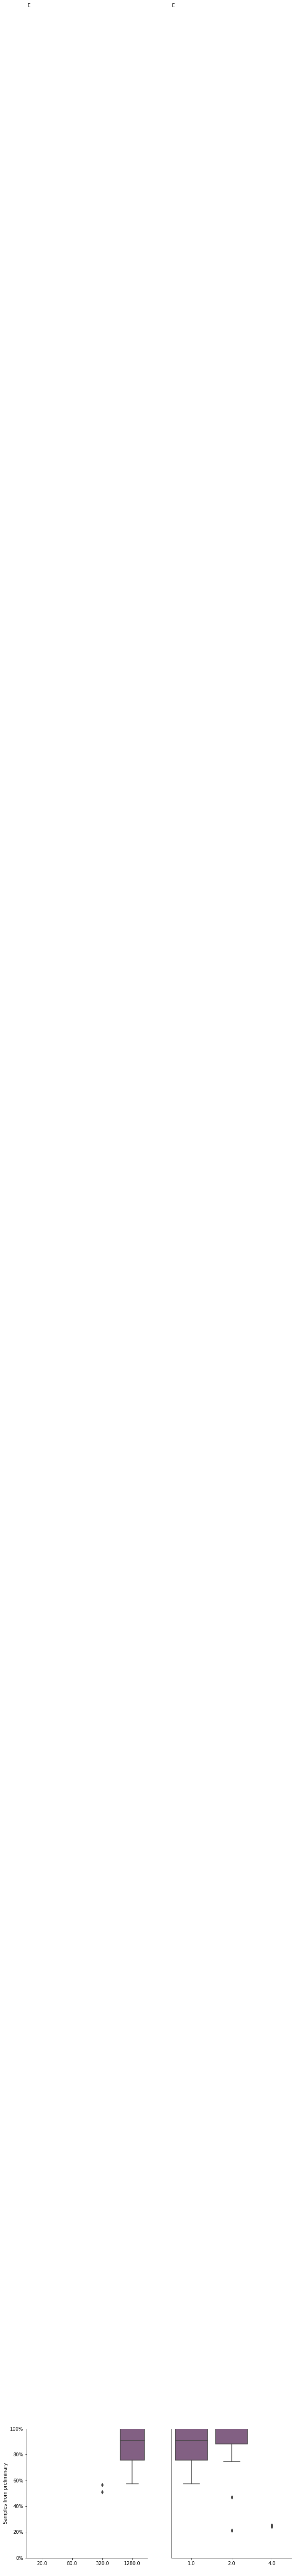

In [9]:
all_acceptances_list=[]
for sleep_i in range(len(sleepvars)):
    acceptances_df = get_acceptance_rates(basepath, nodes, pop_sizes, sleepvars[sleep_i], iters_LA[sleep_i], "Logs_pre")
    all_acceptances_list.append(acceptances_df)
    
all_acceptances_df = pd.concat(all_acceptances_list)

fig,axes=plt.subplots(1,2,figsize=(10,5))

ax = axes[0]

sns.boxplot(x="Pop_size",y="LA fraction", data=all_acceptances_df[all_acceptances_df["sleepvar"]==1],
            ax=ax, color=samplers_color[1])
ax.text(xmin+0.02*(xmax-xmin),ymin+0.95*(ymax-ymin),'E')
ax.set_title(None)
ax.set_xlabel(" ")
ax.set_ylabel("Samples from preliminary")

ax.set_ylim(ymin=0, ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axes[1]

sns.boxplot(x="sleepvar",y="LA fraction", 
            data=all_acceptances_df[all_acceptances_df["Pop_size"]==pop_sizes[-1]],
            ax=ax, color=samplers_color[1])
ax.text(xmin+0.02*(xmax-xmin),ymin+0.95*(ymax-ymin),'E')
ax.set_title(None)
ax.set_xlabel(" ")
#ax.set_ylabel("Samples from preliminary")
ax.set_ylabel(None)
ax.set_ylim(ymin=0,ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)

ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEFinalPrelFraction.pdf"))


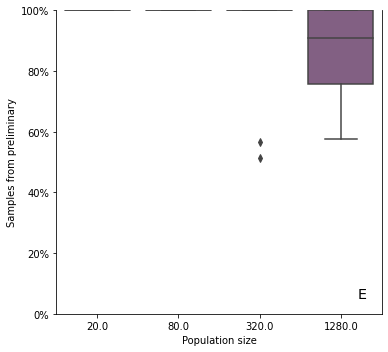

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5.5,5))

sns.boxplot(x="Pop_size",y="LA fraction", data=all_acceptances_df[all_acceptances_df["sleepvar"]==1],
            ax=ax, color=samplers_color[1])
ax.text(3.2,0.05,'E', fontsize="x-large")
ax.set_title(None)
ax.set_xlabel("Population size")
ax.set_ylabel("Samples from preliminary")

ax.set_ylim(ymin=0, ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEPrelFracF.pdf"))


/tmp/ipykernel_2130/2612475238.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


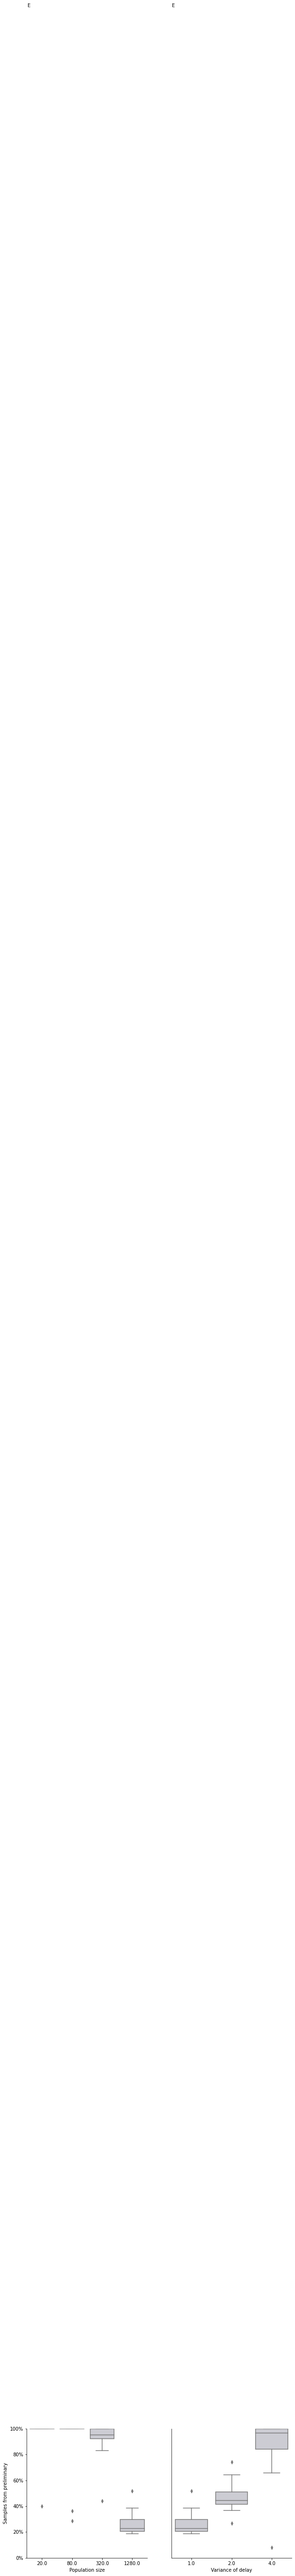

In [11]:
all_acceptances_list_LA=[]
for sleep_i in range(len(sleepvars)):
    acceptances_df = get_acceptance_rates(basepath, nodes, pop_sizes, sleepvars[sleep_i], iters_LA[sleep_i], "Logs")
    all_acceptances_list_LA.append(acceptances_df)
    
all_acceptances_df_LA = pd.concat(all_acceptances_list_LA)

fig,axes=plt.subplots(1,2,figsize=(10,5))

ax = axes[0]

sns.boxplot(x="Pop_size",y="LA fraction", data=all_acceptances_df_LA[all_acceptances_df_LA["sleepvar"]==1],
            ax=ax, color=samplers_color[2])
ax.text(xmin+0.02*(xmax-xmin),ymin+0.95*(ymax-ymin),'E')
ax.set_title(None)
ax.set_xlabel("Population size")
ax.set_ylabel("Samples from preliminary")

ax.set_ylim(ymin=0, ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axes[1]

sns.boxplot(x="sleepvar",y="LA fraction", 
            data=all_acceptances_df_LA[all_acceptances_df_LA["Pop_size"]==pop_sizes[-1]],
            ax=ax, color=samplers_color[2])
ax.text(xmin+0.02*(xmax-xmin),ymin+0.95*(ymax-ymin),'E')
ax.set_title(None)
ax.set_xlabel("Variance of delay")
#ax.set_ylabel("Samples from preliminary")
ax.set_ylabel(None)
ax.set_ylim(ymin=0,ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)

ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEFinalPrelFraction_LA.pdf"))


In [12]:
LA_new_df = all_acceptances_df_LA[all_acceptances_df_LA["sleepvar"]==1]
new_df = all_acceptances_df[all_acceptances_df["sleepvar"]==1]
LA_new_df["Scheduling"] = "DYNLA"
new_df["Scheduling"] = "DYNLA_pre"
new_combine = [new_df, LA_new_df] 
new_df_combine  = pd.concat(new_combine)


/tmp/ipykernel_2130/3540687156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LA_new_df["Scheduling"] = "DYNLA"
/tmp/ipykernel_2130/3540687156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Scheduling"] = "DYNLA_pre"


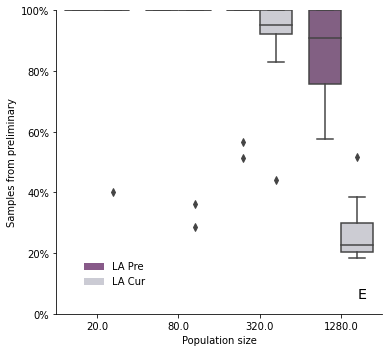

In [13]:


fig,ax = plt.subplots(1,1,figsize=(5.5,5))

sns.boxplot(x="Pop_size",y="LA fraction", data=new_df_combine, hue="Scheduling",
            hue_order=["DYNLA_pre","DYNLA"], ax=ax, palette=[samplers_color[1], samplers_color[2]])
ax.text(3.2,0.05,'E', fontsize="x-large")
ax.set_title(None)
ax.set_xlabel("Population size")
ax.set_ylabel("Samples from preliminary")

ax.set_ylim(ymin=0, ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
labels=["LA Pre", "LA Cur"]
plt.legend([l2,l3],labels, loc='lower right', bbox_to_anchor = (0.3, 0.06), frameon=False)

fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEPrelFracF_v2.pdf"))


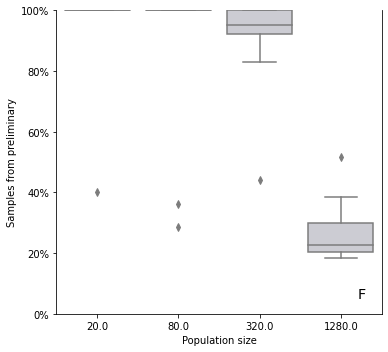

In [14]:
fig,ax = plt.subplots(1,1,figsize=(5.5,5))

sns.boxplot(x="Pop_size",y="LA fraction", data=all_acceptances_df_LA[all_acceptances_df_LA["sleepvar"]==1],
            ax=ax, color=samplers_color[2])
ax.text(3.2,0.05,'F', fontsize="x-large")
ax.set_title(None)
ax.set_xlabel("Population size")
ax.set_ylabel("Samples from preliminary")

ax.set_ylim(ymin=0, ymax=1)

from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig(os.path.join(str(outputpath), "ODEPrelFracF_LA.pdf"))
